# Preliminary analysis of Megaline tariffs

The Megaline Company, a federal mobile operator, offers its customers two tariff plans: Smart and Ultra. To adjust the advertising budget, the commercial department wants to understand which tariff brings in more money.

My task is to make a preliminary analysis of tariffs on a small sample of customers. I have at my disposal the data of 500 Megaline users: who they are, where they are from, what tariff they use, how many calls and messages each sent in 2018. It is necessary to analyze the behavior of customers and draw a conclusion - which tariff is better.


### Data for analysis
The data for the study contains the following categories (columns):

*Users table (user information):*
- user_id - unique user ID
- first_name - username
- last_name - last name of the user
- age — user's age (years)
- reg_date — tariff activation date (day, month, year)
- churn_date — date when the tariff was discontinued (if the value is omitted, then the tariff was still valid at the time of data upload)
- city — user's city of residence
- tariff — tariff plan name

*The Calls table (information about calls):*
- id — unique call number
- call_date — call date
- duration — call duration in minutes
- user_id — identifier of the user who made the call

*Messages table (message information):*
- id — unique message number
- message_date — message date
- user_id — identifier of the user who sent the message

*Internet table (information about internet sessions):*
- id — unique session number
- mb_used - the amount of Internet traffic spent per session (in megabytes)
- session_date — internet session date
- user_id - user ID

*Tariffs table (tariff information):*
- tariff_name — tariff name
- rub_monthly_fee — monthly subscription fee in rubles
- minutes_included - the number of minutes of conversation per month included in the subscription fee
- messages_included - number of messages per month included in the subscription fee
- mb_per_month_included - the amount of Internet traffic included in the subscription fee (in megabytes)
- rub_per_minute - the cost of a minute of conversation in excess of the tariff package (for example, if the tariff includes 100 minutes of conversation per month, then a fee will be charged from 101 minutes)
- rub_per_message - the cost of sending a message in excess of the tariff package
- rub_per_gb - the cost of an additional gigabyte of Internet traffic in excess of the tariff package (1 gigabyte = 1024 megabytes)


### Study plan
In the future work, we will adhere to the following plan:
1. Open data files and study general information
2. Data preparation
   - Convert data to the required types;
   - Find and correct data errors;
   - Calculate for each user:
     - the number of calls made and spent minutes of conversation by month;
     - the number of sent messages by month;
     - the amount of Internet traffic used by months;
     - monthly revenue from each user (subtract the free limit from the total number of calls, messages and Internet traffic; multiply the remainder by the value from the tariff plan; add the subscription fee corresponding to the tariff plan).
3. Analyze the data
   - Describe the behavior of the operator's clients based on the sample.  How many minutes of conversation, how many messages and how much Internet traffic do users of each tariff need per month?  Calculate the mean, variance and standard deviation.  Build histograms.  Describe distributions.
4. Test hypotheses
   - the average revenue of users of the "Ultra" and "Smart" tariffs differs;
   - the average revenue of users from Moscow differs from the revenue of users from other regions (Set the threshold value alpha yourself);
   - Explain:
     - how the null and alternative hypotheses were formulated;
     - what criterion was used to test the hypotheses and why.
5. Write a general conclusion


### Research content
1. [Researching general information](#start)
2. [Data preparation](#preprocessing)
3. [Data analysis](#analysis)
4. [Hypothesis testing](#hypothesis)
5. [General conclusion](#finish)

## Step 1. Researching general Information<a id="start"></a>

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import math
from scipy.stats import levene
#calls = pd.read_csv('calls.csv')
calls = pd.read_csv('/datasets/calls.csv')

In [2]:
calls.info()
calls.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [3]:
#internet = pd.read_csv('internet.csv')
internet = pd.read_csv('/datasets/internet.csv')

In [4]:
internet.info()
internet.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


In [5]:
#messages = pd.read_csv('messages.csv')
messages = pd.read_csv('/datasets/messages.csv')

In [6]:
messages.info()
messages.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [7]:
#tariffs = pd.read_csv('tariffs.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')

In [8]:
tariffs.info()
tariffs.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [9]:
#users = pd.read_csv('users.csv')
users = pd.read_csv('/datasets/users.csv')

In [10]:
users.info()
users.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


## Conclusion

The received data is divided into 5 files. At first glance, the calls of zero duration in the calls file, sessions with zero traffic consumption in the internet file, and the Unnamed: 0 column, which is missing in the original description of the categories in the internet file, attract attention. Let's move on to preparing the data before conducting the study.

## Step 2. Data preparation<a id="preprocessing"></a>

In [11]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [12]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


In [13]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [14]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Based on the results of the analysis of general data, it was noted that all data with dates has the object type.  To work with them, their type must be converted to datetime, which was done.

In [15]:
calls['duration'].value_counts()

0.00     39613
4.49       142
5.50       142
6.15       141
6.38       141
         ...  
27.02        1
26.19        1
25.34        1
27.13        1
24.28        1
Name: duration, Length: 2871, dtype: int64

In [16]:
internet['mb_used'].value_counts()

0.00      19598
197.56        9
447.30        9
335.91        9
108.95        8
          ...  
72.49         1
846.22        1
429.17        1
899.03        1
483.87        1
Name: mb_used, Length: 70003, dtype: int64

The number of zero calls and internet sessions is significant and amounts to about 19.55% and 13.12%, respectively. The possibility of filling in these values by grouping was analyzed, but the amount of information is too small for correct and reasonable filling. On the other hand, there may be technical justifications for the occurrence of such zero values, for example, missed calls from a subscriber or unsuccessful attempts to connect to the Internet. As a result, it was decided to leave these values, but keep them in mind in further calculations and analysis, for example, in the case of determining the number of calls made for each subscriber, these zero calls will not be taken into account.

In [17]:
internet['Unnamed: 0'].unique()

array([     0,      1,      2, ..., 149393, 149394, 149395])

In [18]:
internet.drop(['Unnamed: 0'], axis='columns', inplace=True)
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


Apparently, the column Unnamed: 0 found in the internet file is a technical error - a duplicate of the indexes. It has been removed.

In [19]:
calls['month'] = calls['call_date'].dt.month
calls['duration'] = np.ceil(calls['duration'])
calls['duration'] = calls['duration'].astype('int')
calls.head(20)

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12
5,1000_5,2018-11-02,0,1000,11
6,1000_6,2018-10-18,0,1000,10
7,1000_7,2018-08-22,19,1000,8
8,1000_8,2018-09-15,19,1000,9
9,1000_9,2018-08-15,0,1000,8


In [20]:
calls_per_month = (
    calls
    .query('duration != 0')
    .groupby(['user_id', 'month'])[['duration']].agg(['count', 'sum'])
)
calls_per_month.columns = ['call_count', 'call_duration']
calls_per_month.head(20)

call_count  call_duration
user_id month                           
1000    5              17            159
        6              28            172
        7              41            340
        8              42            408
        9              46            466
        10             44            350
        11             37            338
        12             38            333
1001    11             45            430
        12             47            414
1002    6              14            117
        7              21            214
        8              37            289
        9              25            206
        10             24            212
        11             25            243
        12             27            236
1003    8              43            380
        9             105            961
        10             97            855

In [21]:
internet['month'] = internet['session_date'].dt.month
internet['mb_used'] = np.ceil(internet['mb_used'])
internet['mb_used'] = internet['mb_used'].astype('int')
internet.head(20)

,id,mb_used,session_date,user_id,month
0,1000_0,113,2018-11-25,1000,11
1,1000_1,1053,2018-09-07,1000,9
2,1000_2,1198,2018-06-25,1000,6
3,1000_3,551,2018-08-22,1000,8
4,1000_4,303,2018-09-24,1000,9
5,1000_5,400,2018-10-02,1000,10
6,1000_6,541,2018-09-07,1000,9
7,1000_7,416,2018-07-11,1000,7
8,1000_8,506,2018-10-08,1000,10
9,1000_9,346,2018-09-03,1000,9


In [22]:
internet_per_month = internet.groupby(['user_id', 'month'])[['mb_used']].sum()
internet_per_month.columns = ['internet_used']
internet_per_month.head(20)

internet_used
user_id month               
1000    5               2256
        6              23257
        7              14016
        8              14070
        9              14581
        10             14717
        11             14768
        12              9827
1001    11             18452
        12             14053
1002    6              10871
        7              17601
        8              20347
        9              16712
        10             13905
        11             18610
        12             18137
1003    8               8571
        9              12479
        10             14779

In [23]:
messages['month'] = messages['message_date'].dt.month
messages.head(20)

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12
5,1000_5,2018-06-20,1000,6
6,1000_6,2018-11-19,1000,11
7,1000_7,2018-10-29,1000,10
8,1000_8,2018-06-25,1000,6
9,1000_9,2018-12-18,1000,12


In [24]:
messages_per_month = messages.groupby(['user_id', 'month'])[['message_date']].count()
messages_per_month.columns = ['message_count']
messages_per_month.head(20)

message_count
user_id month               
1000    5                 22
        6                 60
        7                 75
        8                 81
        9                 57
        10                73
        11                58
        12                70
1002    6                  4
        7                 11
        8                 13
        9                  4
        10                10
        11                16
        12                12
1003    8                 37
        9                 91
        10                83
        11                94
        12                75

In [25]:
part_all_per_month = calls_per_month.merge(internet_per_month, on=['user_id', 'month'], how='outer')
all_per_month = part_all_per_month.merge(messages_per_month, on=['user_id', 'month'], how='outer')
all_per_month.reset_index(inplace=True)
all_per_month.head(20)

,user_id,month,call_count,call_duration,internet_used,message_count
0,1000,5,17.0,159.0,2256.0,22.0
1,1000,6,28.0,172.0,23257.0,60.0
2,1000,7,41.0,340.0,14016.0,75.0
3,1000,8,42.0,408.0,14070.0,81.0
4,1000,9,46.0,466.0,14581.0,57.0
5,1000,10,44.0,350.0,14717.0,73.0
6,1000,11,37.0,338.0,14768.0,58.0
7,1000,12,38.0,333.0,9827.0,70.0
8,1001,11,45.0,430.0,18452.0,NaN
9,1001,12,47.0,414.0,14053.0,NaN


In [26]:
all_per_month['internet_used'].sum(), internet['mb_used'].sum(),

(55369459.0, 55369459)

Since the formulation of the following questions and stages of our analysis requires determining the actions of each user per month, the data from the calls, internet and messages tables were grouped by user ID and month number with the definition of the number and amount of call duration, the amount of traffic spent and the number of messages. These tables were later merged together to generate usage statistics for each user in each month in 2018.

In [27]:
all_per_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 6 columns):
user_id          3214 non-null int64
month            3214 non-null int64
call_count       3168 non-null float64
call_duration    3168 non-null float64
internet_used    3203 non-null float64
message_count    2717 non-null float64
dtypes: float64(4), int64(2)
memory usage: 150.8 KB


In [28]:
all_per_month = all_per_month.fillna(0)
all_per_month['call_count'] = all_per_month['call_count'].astype('int')
all_per_month['call_duration'] = all_per_month['call_duration'].astype('int')
all_per_month['internet_used'] = all_per_month['internet_used'].astype('int')
all_per_month['message_count'] = all_per_month['message_count'].astype('int')
all_per_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 6 columns):
user_id          3214 non-null int64
month            3214 non-null int64
call_count       3214 non-null int64
call_duration    3214 non-null int64
internet_used    3214 non-null int64
message_count    3214 non-null int64
dtypes: int64(6)
memory usage: 150.8 KB


After merging the tables of statistics on the use of mobile communication services, attention was drawn to the presence of gaps in the columns call_count, call_duration, mb_used and message_count. This probably indicates that the user did not use the services of calls, Internet and messages in certain months. These gaps were filled with zeros. Additionally, since these columns can only have integer values, their type has been changed to int.

In [29]:
users_per_month = all_per_month.merge(users, on='user_id', how='left', suffixes=('_per_month', '_users'))
users_per_month.info()
users_per_month.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 13 columns):
user_id          3214 non-null int64
month            3214 non-null int64
call_count       3214 non-null int64
call_duration    3214 non-null int64
internet_used    3214 non-null int64
message_count    3214 non-null int64
age              3214 non-null int64
churn_date       187 non-null datetime64[ns]
city             3214 non-null object
first_name       3214 non-null object
last_name        3214 non-null object
reg_date         3214 non-null datetime64[ns]
tariff           3214 non-null object
dtypes: datetime64[ns](2), int64(7), object(4)
memory usage: 351.5+ KB


,user_id,month,call_count,call_duration,internet_used,message_count,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,17,159,2256,22,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,28,172,23257,60,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,41,340,14016,75,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,42,408,14070,81,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,46,466,14581,57,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
5,1000,10,44,350,14717,73,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
6,1000,11,37,338,14768,58,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
7,1000,12,38,333,9827,70,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
8,1001,11,45,430,18452,0,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
9,1001,12,47,414,14053,0,41,NaT,Москва,Иван,Ежов,2018-11-01,smart


Next, the monthly statistics table was merged with data from the users table to obtain an overall table of statistics and detailed information about users. This table will be used for further calculations and analysis.

In [30]:
for i in range(len(users_per_month)):
    if users_per_month.loc[i, 'tariff'] == 'smart':
        if users_per_month.loc[i, 'call_duration'] > tariffs.loc[0, 'minutes_included']:
            users_per_month.loc[i, 'call_fee_add'] = (users_per_month.loc[i, 'call_duration'] - tariffs.loc[0, 'minutes_included']) * tariffs.loc[0, 'rub_per_minute']
        else:
            users_per_month.loc[i, 'call_fee_add'] = 0
    elif users_per_month.loc[i, 'tariff'] == 'ultra':
        if users_per_month.loc[i, 'call_duration'] > tariffs.loc[1, 'minutes_included']:
            users_per_month.loc[i, 'call_fee_add'] = (users_per_month.loc[i, 'call_duration'] - tariffs.loc[1, 'minutes_included']) * tariffs.loc[1, 'rub_per_minute']
        else:
            users_per_month.loc[i, 'call_fee_add'] = 0
    else:
        pass

In [31]:
users_per_month['call_fee_add'] = users_per_month['call_fee_add'].astype('int')

In [32]:
for i in range(len(users_per_month)):
    if users_per_month.loc[i, 'tariff'] == 'smart':
        if users_per_month.loc[i, 'internet_used'] > tariffs.loc[0, 'mb_per_month_included']:
            users_per_month.loc[i, 'internet_fee_add'] = ((users_per_month.loc[i, 'internet_used'] - tariffs.loc[0, 'mb_per_month_included']) / 1024) * tariffs.loc[0, 'rub_per_gb']
        else:
            users_per_month.loc[i, 'internet_fee_add'] = 0
    elif users_per_month.loc[i, 'tariff'] == 'ultra':
        if users_per_month.loc[i, 'internet_used'] > tariffs.loc[1, 'mb_per_month_included']:
            users_per_month.loc[i, 'internet_fee_add'] = ((users_per_month.loc[i, 'internet_used'] - tariffs.loc[1, 'mb_per_month_included']) / 1024) * tariffs.loc[1, 'rub_per_gb']
        else:
            users_per_month.loc[i, 'internet_fee_add'] = 0
    else:
        pass

In [33]:
users_per_month['internet_fee_add'] = users_per_month['internet_fee_add'].astype('int')

In [34]:
for i in range(len(users_per_month)):
    if users_per_month.loc[i, 'tariff'] == 'smart':
        if users_per_month.loc[i, 'message_count'] > tariffs.loc[0, 'messages_included']:
            users_per_month.loc[i, 'messages_fee_add'] = (users_per_month.loc[i, 'message_count'] - tariffs.loc[0, 'messages_included']) * tariffs.loc[0, 'rub_per_message']
        else:
            users_per_month.loc[i, 'messages_fee_add'] = 0
    elif users_per_month.loc[i, 'tariff'] == 'ultra':
        if users_per_month.loc[i, 'message_count'] > tariffs.loc[1, 'messages_included']:
            users_per_month.loc[i, 'messages_fee_add'] = (users_per_month.loc[i, 'message_count'] - tariffs.loc[1, 'messages_included']) * tariffs.loc[1, 'rub_per_message']
        else:
            users_per_month.loc[i, 'messages_fee_add'] = 0
    else:
        pass

In [35]:
users_per_month['messages_fee_add'] = users_per_month['messages_fee_add'].astype('int')

In [36]:
for i in range(len(users_per_month)):
    if users_per_month.loc[i, 'tariff'] == 'smart':
        users_per_month.loc[i, 'full_fee'] = tariffs.loc[0, 'rub_monthly_fee'] + users_per_month.loc[i, 'call_fee_add'] + users_per_month.loc[i, 'internet_fee_add'] + users_per_month.loc[i, 'messages_fee_add']
    elif users_per_month.loc[i, 'tariff'] == 'ultra':
        users_per_month.loc[i, 'full_fee'] = tariffs.loc[1, 'rub_monthly_fee'] + users_per_month.loc[i, 'call_fee_add'] + users_per_month.loc[i, 'internet_fee_add'] + users_per_month.loc[i, 'messages_fee_add']
    else:
        pass

In [37]:
users_per_month['full_fee'] = users_per_month['full_fee'].astype('int')

In [38]:
users_per_month.info()
users_per_month.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 17 columns):
user_id             3214 non-null int64
month               3214 non-null int64
call_count          3214 non-null int64
call_duration       3214 non-null int64
internet_used       3214 non-null int64
message_count       3214 non-null int64
age                 3214 non-null int64
churn_date          187 non-null datetime64[ns]
city                3214 non-null object
first_name          3214 non-null object
last_name           3214 non-null object
reg_date            3214 non-null datetime64[ns]
tariff              3214 non-null object
call_fee_add        3214 non-null int64
internet_fee_add    3214 non-null int64
messages_fee_add    3214 non-null int64
full_fee            3214 non-null int64
dtypes: datetime64[ns](2), int64(11), object(4)
memory usage: 612.0+ KB


,user_id,month,call_count,call_duration,internet_used,message_count,age,churn_date,city,first_name,last_name,reg_date,tariff,call_fee_add,internet_fee_add,messages_fee_add,full_fee
0,1000,5,17,159,2256,22,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0,0,0,1950
1,1000,6,28,172,23257,60,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0,0,0,1950
2,1000,7,41,340,14016,75,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0,0,0,1950
3,1000,8,42,408,14070,81,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0,0,0,1950
4,1000,9,46,466,14581,57,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0,0,0,1950
5,1000,10,44,350,14717,73,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0,0,0,1950
6,1000,11,37,338,14768,58,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0,0,0,1950
7,1000,12,38,333,9827,70,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0,0,0,1950
8,1001,11,45,430,18452,0,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,0,603,0,1153
9,1001,12,47,414,14053,0,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,0,0,0,550


To calculate the final total monthly subscription fee for each user (monthly revenue from each user), the amounts of additional charges for calls, Internet and messages were sequentially calculated, in case their use exceeded the terms of the tariff, with their subsequent addition to the monthly subscription fee according to the tariff. The totals have been stored in the full_fee column.
After preparing all the data and performing calculations, we proceed to the analysis.

## Step 3. Data analysis<a id="analysis"></a>

In [39]:
users_per_month_smart = users_per_month.query('tariff == "smart"')
users_per_month_ultra = users_per_month.query('tariff == "ultra"')

In [40]:
call_duration_smart_mean = users_per_month_smart['call_duration'].mean()
print('Среднее выборки использованных минут разговора абонентов тарифа "Смарт":',
      call_duration_smart_mean)

Среднее выборки использованных минут разговора абонентов тарифа "Смарт": 417.9349484073576


In [41]:
call_duration_smart_estimate = np.var(users_per_month_smart['call_duration'], ddof=1)
print('Дисперсия выборки использованных минут разговора абонентов тарифа "Смарт":',
      call_duration_smart_estimate)

Дисперсия выборки использованных минут разговора абонентов тарифа "Смарт": 36219.31578434428


In [42]:
call_duration_smart_standard_deviation = np.std(users_per_month_smart['call_duration'])
print('Стандартное отклонение выборки использованных минут разговора абонентов тарифа "Смарт":',
      call_duration_smart_standard_deviation)

Стандартное отклонение выборки использованных минут разговора абонентов тарифа "Смарт": 190.27103471651876


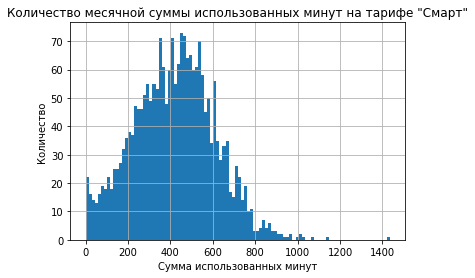

In [43]:
users_per_month_smart['call_duration'].hist(bins=100)
plt.title('Количество месячной суммы использованных минут на тарифе "Смарт"')
plt.xlabel('Сумма использованных минут')
plt.ylabel('Количество')
plt.show()

In [44]:
call_duration_smart_upper = call_duration_smart_mean + 3 * call_duration_smart_standard_deviation
print('Верхняя граница распределения выборки использованных минут разговора абонентов тарифа "Смарт":',
      call_duration_smart_upper)

Верхняя граница распределения выборки использованных минут разговора абонентов тарифа "Смарт": 988.7480525569138


In [45]:
call_duration_smart_lower = call_duration_smart_mean - 3 * call_duration_smart_standard_deviation
print('Нижняя граница распределения выборки использованных минут разговора абонентов тарифа "Смарт":',
      call_duration_smart_lower)

Нижняя граница распределения выборки использованных минут разговора абонентов тарифа "Смарт": -152.87815574219866


Subscribers of the "Smart" tariff on average use about 417 minutes per month, which is less than the number of minutes included in the subscription fee for this tariff (500 minutes), but the maximum probable value of the sum of the number of minutes used can be about 988 minutes, which is much more than the number of minutes included  minutes and can bring additional profit to the operator.

In [46]:
call_duration_ultra_mean = users_per_month_ultra['call_duration'].mean()
print('Среднее выборки использованных минут разговора абонентов тарифа "Ультра":',
      call_duration_ultra_mean)

Среднее выборки использованных минут разговора абонентов тарифа "Ультра": 526.6233502538071


In [47]:
call_duration_ultra_estimate = np.var(users_per_month_ultra['call_duration'], ddof=1)
print('Дисперсия выборки использованных минут разговора абонентов тарифа "Ультра":',
      call_duration_ultra_estimate)

Дисперсия выборки использованных минут разговора абонентов тарифа "Ультра": 100873.63339730098


In [48]:
call_duration_ultra_standard_deviation = np.std(users_per_month_ultra['call_duration'])
print('Стандартное отклонение выборки использованных минут разговора абонентов тарифа "Ультра":',
      call_duration_ultra_standard_deviation)

Стандартное отклонение выборки использованных минут разговора абонентов тарифа "Ультра": 317.44483554974113


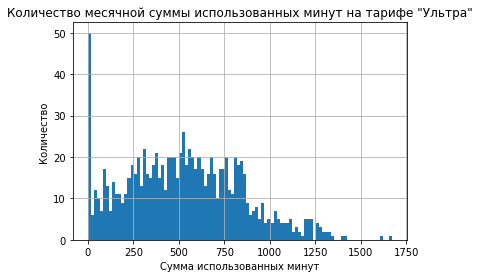

In [49]:
users_per_month_ultra['call_duration'].hist(bins=100)
plt.title('Количество месячной суммы использованных минут на тарифе "Ультра"')
plt.xlabel('Сумма использованных минут')
plt.ylabel('Количество')
plt.show()

In [50]:
call_duration_ultra_upper = call_duration_ultra_mean + 3 * call_duration_ultra_standard_deviation
print('Верхняя граница распределения выборки использованных минут разговора абонентов тарифа "Ультра":',
      call_duration_ultra_upper)

Верхняя граница распределения выборки использованных минут разговора абонентов тарифа "Ультра": 1478.9578569030305


In [51]:
call_duration_ultra_lower = call_duration_ultra_mean - 3 * call_duration_ultra_standard_deviation
print('Нижняя граница распределения выборки использованных минут разговора абонентов тарифа "Ультра":',
      call_duration_ultra_lower)

Нижняя граница распределения выборки использованных минут разговора абонентов тарифа "Ультра": -425.7111563954163


The average value of the monthly use of minutes of conversation for the users of the "Ultra" tariff (about 526 minutes) turned out to be higher than for the users of the "Smart" tariff and more than the number of included minutes in the "Smart" tariff (500 minutes), which indicates that, on average, users  tariff "Ultra" made the right decision using it, since the tariff "Smart" they would have to pay for minutes of conversation, in addition to those included in the tariff.  At the same time, the maximum probable value of the number of minutes used is approximately 1478 minutes, which indicates that the use of at least half of the included minutes is unlikely, not to mention the full package of minutes in the tariff. This situation is seen as beneficial for the operator.

In [52]:
message_count_smart_mean = users_per_month_smart['message_count'].mean()
print('Среднее выборки использованных сообщений абонентов тарифа "Смарт":',
      message_count_smart_mean)

Среднее выборки использованных сообщений абонентов тарифа "Смарт": 33.384028712427096


In [53]:
message_count_smart_estimate = np.var(users_per_month_smart['message_count'], ddof=1)
print('Дисперсия выборки использованных сообщений абонентов тарифа "Смарт":',
      message_count_smart_estimate)

Дисперсия выборки использованных сообщений абонентов тарифа "Смарт": 796.8129584480083


In [54]:
message_count_smart_standard_deviation = np.std(users_per_month_smart['message_count'])
print('Стандартное отклонение выборки использованных сообщений абонентов тарифа "Смарт":',
      message_count_smart_standard_deviation)

Стандартное отклонение выборки использованных сообщений абонентов тарифа "Смарт": 28.221542886898938


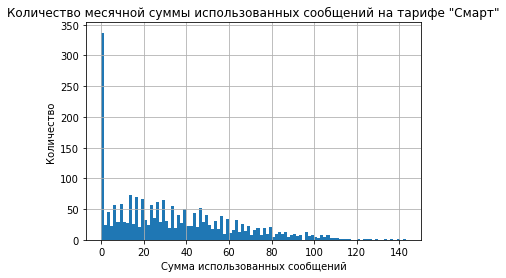

In [55]:
users_per_month_smart['message_count'].hist(bins=100)
plt.title('Количество месячной суммы использованных сообщений на тарифе "Смарт"')
plt.xlabel('Сумма использованных сообщений')
plt.ylabel('Количество')
plt.show()

In [56]:
message_count_smart_upper = message_count_smart_mean + 3 * message_count_smart_standard_deviation
print('Верхняя граница распределения выборки использованных сообщений абонентов тарифа "Смарт":',
      message_count_smart_upper)

Верхняя граница распределения выборки использованных сообщений абонентов тарифа "Смарт": 118.04865737312392


In [57]:
message_count_smart_lower = message_count_smart_mean - 3 * message_count_smart_standard_deviation
print('Нижняя граница распределения выборки использованных сообщений абонентов тарифа "Смарт":',
      message_count_smart_lower)

Нижняя граница распределения выборки использованных сообщений абонентов тарифа "Смарт": -51.280599948269725


The average value of the monthly use of messages by users of the "Smart" tariff is approximately 33 pieces, which is less than the number included in the tariff. The standard deviation puts us at an upper bound on the likely monthly usage of messages at around 118. Additionally, there is a large amount of zero message usage in the histogram. This situation seems to be normal, since now the writing of ordinary SMS is really strongly supplanted by online messengers. Thus, although the average trend in using messages less than the included package does not bring additional money, a significant part of users do not use them at all, which suggests that this is still beneficial for the operator.

In [58]:
message_count_ultra_mean = users_per_month_ultra['message_count'].mean()
print('Среднее выборки использованных сообщений абонентов тарифа "Ультра":',
      message_count_ultra_mean)

Среднее выборки использованных сообщений абонентов тарифа "Ультра": 49.36345177664975


In [59]:
message_count_ultra_estimate = np.var(users_per_month_ultra['message_count'], ddof=1)
print('Дисперсия выборки использованных сообщений абонентов тарифа "Ультра":',
      message_count_ultra_estimate)

Дисперсия выборки использованных сообщений абонентов тарифа "Ультра": 2285.2661425446736


In [60]:
message_count_ultra_standard_deviation = np.std(users_per_month_ultra['message_count'])
print('Стандартное отклонение выборки использованных сообщений абонентов тарифа "Ультра":',
      message_count_ultra_standard_deviation)

Стандартное отклонение выборки использованных сообщений абонентов тарифа "Ультра": 47.78018496610161


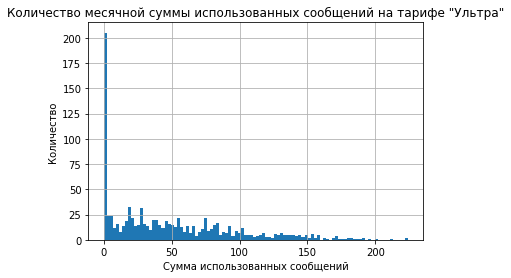

In [61]:
users_per_month_ultra['message_count'].hist(bins=100)
plt.title('Количество месячной суммы использованных сообщений на тарифе "Ультра"')
plt.xlabel('Сумма использованных сообщений')
plt.ylabel('Количество')
plt.show()

In [62]:
message_count_ultra_upper = message_count_ultra_mean + 3 * message_count_ultra_standard_deviation
print('Верхняя граница распределения выборки использованных сообщений абонентов тарифа "Ультра":',
      message_count_ultra_upper)

Верхняя граница распределения выборки использованных сообщений абонентов тарифа "Ультра": 192.70400667495457


In [63]:
message_count_ultra_lower = message_count_ultra_mean - 3 * message_count_ultra_standard_deviation
print('Нижняя граница распределения выборки использованных сообщений абонентов тарифа "Ультра":',
      message_count_ultra_lower)

Нижняя граница распределения выборки использованных сообщений абонентов тарифа "Ультра": -93.97710312165506


The situation in terms of messages for users of the "Ultra" tariff is similar to the "Smart" tariff - the average usage value is less than the included package (about 49 messages per month, which for this tariff is much less than the included package) and a significant number of subscribers who do not use messages at all.  In general, this situation is positive for the operator, since the user in any case pays for the included message package, but either uses it very little or does not use it at all.

In [64]:
internet_used_smart_mean = users_per_month_smart['internet_used'].mean()
print('Среднее выборки использованного интернета абонентов тарифа "Смарт":',
      internet_used_smart_mean)

Среднее выборки использованного интернета абонентов тарифа "Смарт": 16229.188425302826


In [65]:
internet_used_smart_estimate = np.var(users_per_month_smart['internet_used'], ddof=1)
print('Дисперсия выборки использованного интернета абонентов тарифа "Смарт":',
      internet_used_smart_estimate)

Дисперсия выборки использованного интернета абонентов тарифа "Смарт": 34545911.12695753


In [66]:
internet_used_smart_standard_deviation = np.std(users_per_month_smart['internet_used'])
print('Стандартное отклонение выборки использованного интернета абонентов тарифа "Смарт":',
      internet_used_smart_standard_deviation)

Стандартное отклонение выборки использованного интернета абонентов тарифа "Смарт": 5876.25839604077


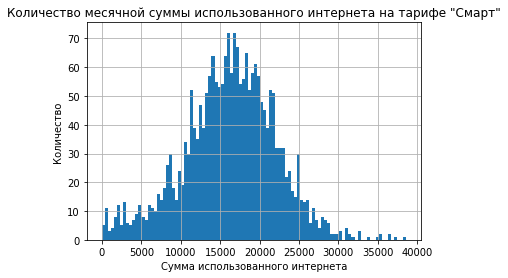

In [67]:
users_per_month_smart['internet_used'].hist(bins=100)
plt.title('Количество месячной суммы использованного интернета на тарифе "Смарт"')
plt.xlabel('Сумма использованного интернета')
plt.ylabel('Количество')
plt.show()

In [68]:
internet_used_smart_upper = internet_used_smart_mean + 3 * internet_used_smart_standard_deviation
print('Верхняя граница распределения выборки использованного интернета абонентов тарифа "Смарт":',
      internet_used_smart_upper)

Верхняя граница распределения выборки использованного интернета абонентов тарифа "Смарт": 33857.963613425134


In [69]:
internet_used_smart_lower = internet_used_smart_mean - 3 * internet_used_smart_standard_deviation
print('Нижняя граница распределения выборки использованного интернета абонентов тарифа "Смарт":',
      internet_used_smart_lower)

Нижняя граница распределения выборки использованного интернета абонентов тарифа "Смарт": -1399.5867628194828


The average monthly use of the Internet on the "Smart" tariff is approximately 16229 MB or 15.84 GB, which, although not much, is still more than the package included in the tariff. At the same time, the upper limit of the probable monthly use is at the level of 33,857 MB, or approximately 33 GB, which is more than twice the volume of the included Internet. This is positive news for the operator, since on average subscribers of this tariff overpay a little, and in some probable cases they can overpay much more.

In [70]:
internet_used_ultra_mean = users_per_month_ultra['internet_used'].mean()
print('Среднее выборки использованного интернета абонентов тарифа "Ультра":',
      internet_used_ultra_mean)

Среднее выборки использованного интернета абонентов тарифа "Ультра": 19486.90152284264


In [71]:
internet_used_ultra_estimate = np.var(users_per_month_ultra['internet_used'], ddof=1)
print('Дисперсия выборки использованного интернета абонентов тарифа "Ультра":',
      internet_used_ultra_estimate)

Дисперсия выборки использованного интернета абонентов тарифа "Ультра": 101935621.04821923


In [72]:
internet_used_ultra_standard_deviation = np.std(users_per_month_ultra['internet_used'])
print('Стандартное отклонение выборки использованного интернета абонентов тарифа "Ультра":',
      internet_used_ultra_standard_deviation)

Стандартное отклонение выборки использованного интернета абонентов тарифа "Ультра": 10091.190866695008


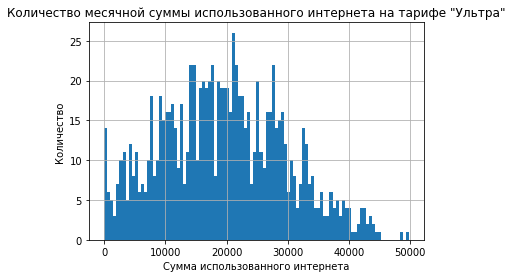

In [73]:
users_per_month_ultra['internet_used'].hist(bins=100)
plt.title('Количество месячной суммы использованного интернета на тарифе "Ультра"')
plt.xlabel('Сумма использованного интернета')
plt.ylabel('Количество')
plt.show()

In [74]:
internet_used_ultra_upper = internet_used_ultra_mean + 3 * internet_used_ultra_standard_deviation
print('Верхняя граница распределения выборки использованного интернета абонентов тарифа "Ультра":',
      internet_used_ultra_upper)

Верхняя граница распределения выборки использованного интернета абонентов тарифа "Ультра": 49760.47412292766


In [75]:
internet_used_ultra_lower = internet_used_ultra_mean - 3 * internet_used_ultra_standard_deviation
print('Нижняя граница распределения выборки использованного интернета абонентов тарифа "Ультра":',
      internet_used_ultra_lower)

Нижняя граница распределения выборки использованного интернета абонентов тарифа "Ультра": -10786.671077242383


In terms of the Internet, the monthly situation for the "Ultra" tariff differs from the "Smart" tariff.  The average monthly Internet consumption is 19,486 MB or approximately 19 GB, which is almost a third less than the included 30 GB package. That is, subscribers of this tariff, on average, use the Internet at a fairly good level, using more than half of the included package, but do not go beyond its threshold and do not pay extra to the operator. At the same time, the upper probable limit is about 49,760 MB, or about 48.59 GB, which is already much more than the included package. In general, the situation for the operator can be described as neutral - on average, subscribers use the Internet at a good level, but do not go beyond the included package, there is a possibility of exceeding the included Internet level by a significant amount, which can bring additional money to the operator.

## Step 4. Hypothesis testing<a id="hypothesis"></a>

In [76]:
stat, p1 = levene(users_per_month_smart['full_fee'], users_per_month_ultra['full_fee'])
print('p-значение по методу Левене для проверки равенства дисперсий двух выборок:', p1)

p-значение по методу Левене для проверки равенства дисперсий двух выборок: 4.026304260461603e-115


In [77]:
alpha1 = .05

results1 = st.ttest_ind(
    users_per_month_smart['full_fee'], 
    users_per_month_ultra['full_fee'],
    equal_var = False)

print('p-значение:', results1.pvalue)

if (results1.pvalue < alpha1):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 5.133013116078655e-296
Отвергаем нулевую гипотезу


The hypothesis "the average revenue of users of Ultra" and "Smart" tariffs differs first was tested.
The null hypothesis in this case was formulated as "the average revenue of users of the Ultra" and "Smart" tariffs is equal", and the alternative one - as "the average revenue of users of the "Ultra" and "Smart" tariffs is not equal (different)". The level of statistical significance (alpha) was chosen at 5%. Additionally, the null hypothesis was tested about the equality of the variances of the two samples using the scipy.stats.levene method.  This method was chosen visually established deviations from the normality of the analyzed samples.  As a result, the value of p turned out to be very small, which indicates that the equality of the variances could not be confirmed - the equal_var parameter was set to False.
According to the results of the calculations, the null hypothesis was rejected, which indicates that the originally formulated hypothesis "the average revenue of users of the Ultra and Smart tariffs differs" turned out to be correct.
The selected level of statistical significance did not affect the results of the analysis, since the level of significance of the difference statistics (p-value) turned out to be very small, in fact tending to zero.

In [78]:
users_per_month_moscow = users_per_month.query('city == "Москва"')
users_per_month_other = users_per_month.query('city != "Москва"')

In [79]:
stat, p2 = levene(users_per_month_moscow['full_fee'], users_per_month_other['full_fee'])
print('p-значение по методу Левене для проверки равенства дисперсий двух выборок:', p2)

p-значение по методу Левене для проверки равенства дисперсий двух выборок: 0.021439825608542448


In [80]:
alpha2 = .05

results2 = st.ttest_ind(
    users_per_month_moscow['full_fee'], 
    users_per_month_other['full_fee'],
    equal_var = False)

print('p-значение:', results2.pvalue)

if (results2.pvalue < alpha2):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.4546446281204245
Не получилось отвергнуть нулевую гипотезу


The second tested the hypothesis "the average revenue of users from Moscow differs from the revenue of users from other regions."  The null hypothesis in this case was formulated as "the average revenue of users from Moscow is equal to the revenue of users from other regions", and the alternative one - as "the average revenue of users from Moscow is not equal (different) to the revenue of users from other regions". The level of statistical significance (alpha) was chosen at 5%. Additionally, the null hypothesis was tested about the equality of the variances of the two samples using the scipy.stats.levene method. As a result, the value of p turned out to be small, which indicates that the equality of the variances could not be confirmed - the equal_var parameter was set to False.  According to the results of the calculations, the null hypothesis was not rejected, which means that the originally formulated hypothesis "the average revenue of users from Moscow differs from the revenue of users from other regions" is not true. The selected level of statistical significance did not affect the results of the analysis, since the level of significance of the difference statistics (p-value) turned out to be significantly higher (about 45% versus 5%).

## Step 5. General conclusion<a id="finish"></a>

The analysis of a sample of 500 users of the "Smart" and "Ultra" tariff plans of the operator "Megaline" showed that the level of use of the minutes of conversation, messages and the Internet included in the tariffs, and, accordingly, the need for additional payment to the operator in excess of the monthly fee, differs.

In terms of the use of minutes of conversation per month, the average value for both tariffs is less than the included package, but for the "Smart" tariff, unlike the "Ultra" tariff, the upper limit of the probable average use of calls is almost twice the size of the included minutes. The "Ultra" tariff has an upper limit less than the value of the package of minutes. In terms of conversations, the "Smart" tariff looks more profitable.
The rates are reported to be about the same. Although the "Smart" tariff also has an excess of the included package when considering the upper limit of the probable average usage (there is no excess for the "Ultra" tariff), both tariffs have a significant number of users who do not use messages at all, which makes the "Ultra" tariff preferable, since it includes a much larger volume of messages that are often not used, which is beneficial for the operator - money in the form of a monthly fee is received for an unused service.
The Internet is used by subscribers of the considered tariffs in different ways. On the "Smart" tariff, both the average value and the upper limit of the probable values exceed the volume of the Internet included in the tariff, which, together with the higher cost of additional GB compared to the "Ultra", is the most beneficial factor for the operator. For the "Ultra" tariff, the situation is more neutral - on average, subscribers use the Internet at a good level, do not go beyond the included package, but there is a possibility of exceeding the included Internet level by a significant amount.

In the aggregate of the considered factors, the "Smart" tariff seems to be more profitable for the operator, since the probability of exceeding the included packages and receiving additional payment for services on it is higher, also taking into account the fact that the cost of additional services on it is higher than that of the "Ultra" tariff.

Additionally, as part of the analysis, two hypotheses were tested: "the average revenue of users of the "Ultra" and "Smart" tariffs differs" and "the average revenue of users from Moscow differs from the revenue of users from other regions". The first of them turned out to be true, the second - no. This suggests that it is likely that the average level of revenue from Smart and Ultra tariffs is different, and it is also likely that the average revenue of users from Moscow and other cities correspond to each other.